In [1]:
"""Initialization"""
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm
import time
from numpy.linalg import inv

np.random.seed(123)

# **Q.4 A first Gibbs sampler**

**Q4.1 - Visualizing the burn-in period.**

The hyperparameters $\beta$, $\mu$ and $\sigma$ are set accordingly to the TrueSkill paper with $\mu = 25$, $\sigma = (25/3)^2$ and $\beta = 25/6$.

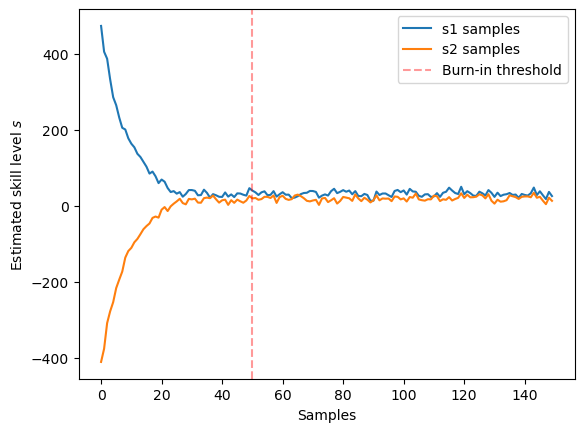

In [2]:
#Set up hyperparameters
mu = 25  # prior mean for both players
sigma = (25/3)**2  # prior standard deviation for both players
beta = 25/6  # variance for performance difference

#t is initial guess, intial guess of t used
#to sample from s1, s2 --> then t. (t is given)

A = np.array([[1], [-1]])
beta = 25/6
mu = 25
sigma = (25/3)**2
mu_matrix = np.array([[mu], [mu]])
sig_matrix = np.array([[sigma, 0], [0, sigma]])

# Function to sample s1 given s2 and t
def sample_s(sig_matrix, A, beta, mu_matrix, t):
    #Calculate Sigma of s given t
    sigma_s_t = np.linalg.inv(np.linalg.inv(sig_matrix) + (A @ A.T) / (beta**2))

    #Calculate mu of s given t
    mu_s_t = sigma_s_t @ (np.linalg.inv(sig_matrix) @ mu_matrix +\
                         (t / (beta**2)) * A)

    #Flatten (multivariate functions needs that)
    mu_s_t = mu_s_t.flatten()

    # Sample s1, s2 from the multivariate normal distribution
    s1, s2 = np.random.multivariate_normal(mu_s_t, sigma_s_t)
    return s1, s2

# Function to sample t (the performance difference) using truncated normal
def sample_t(s1, s2, beta, y):
    mean_t = s1 - s2
    if y == 1:
        a, b = 0, np.inf  # t is truncated at 0 from below
    else:
        a, b = -np.inf, 0  # t is truncated at 0 from above
    
    #Handling errors (debugging method)
    try: t = stats.truncnorm.rvs(a=(a - mean_t) / beta,\
                            b=(b - mean_t) / beta,\
                            loc=mean_t, scale=beta) 
    
    except ValueError:
        print(f"\nValueError! a={a}, b={b}, mean_t={mean_t}, beta={beta}\n")
        raise
    return t


# Gibbs Sampler
def gibbs_sampler(num_iterations, y, initial_t):
    # Initialize s1 and s2 with their prior means
    s = mu
    t = initial_t #Initial guess

    # Store samples of s1 and s2
    samples_s1 = []
    samples_s2 = []
    iterations = []

    for i in range(num_iterations):

        # Sample s1 given t and s2
        s1, s2 = sample_s(sig_matrix, A, beta, mu_matrix, t)

        # Sample t given s1, s2, and y
        t = sample_t(s1, s2, beta, y)

        # Append samples to lists
        samples_s1.append(s1)
        samples_s2.append(s2)
        iterations.append(i)

    return np.array(samples_s1), np.array(samples_s2), iterations

# Example: Run Gibbs Sampler with 1000 iterations
num_iterations = 150
y = 1  # Player 1 wins
burn_in = 50
initial_t = 1000
samples_s1, samples_s2, iterations = gibbs_sampler(num_iterations, y, initial_t)


#Plot samples to see stationary distribution and burn in period

plt.plot(iterations, samples_s1, label ='s1 samples')
plt.plot(iterations, samples_s2, label ='s2 samples')
plt.xlabel("Samples")
plt.ylabel(r"Estimated skill level $s$")

plt.axvline(x=burn_in, color='red', linestyle='--', label='Burn-in threshold',\
            alpha=0.4)
plt.legend()
plt.show()

The graph indicates that the burn-in period ends after approximately 50 iterations when an extreme initial guess of $t=5000$ is made. Initial guesses of $t>100$ makes the burn-in period visualized whereas approximately $t<100$ converges almost directly, due to t (the difference in skill level) being closer to the true difference.

**Q4.2 - Finding the gaussian approximation of the samples**

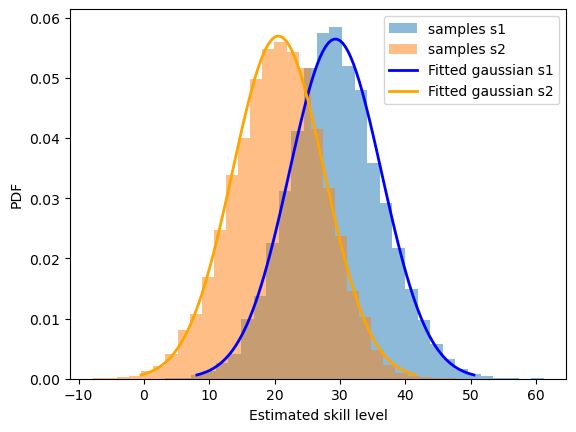

In [3]:
num_iterations = 10000
initial_t = 0
y = 1  # Player 1 wins
burn_in = 50
samples_s1, samples_s2, iterations = gibbs_sampler(num_iterations, y, initial_t)

s1_mean = np.mean(samples_s1)
s1_variance = np.var(samples_s1)
s2_mean = np.mean(samples_s2)
s2_variance = np.var(samples_s2)

plt.show

# Create an array of x values for plotting
x1 = np.linspace(s1_mean - 3 * np.sqrt(s1_variance),\
                 s1_mean + 3 * np.sqrt(s1_variance), 100)

x2 = np.linspace(s2_mean - 3 * np.sqrt(s2_variance),\
                 s2_mean + 3 * np.sqrt(s2_variance), 100)

pdf_gibbs_s1 = stats.norm.pdf(x1, s1_mean, np.sqrt(s1_variance))
pdf_gibbs_s2 = stats.norm.pdf(x2, s2_mean, np.sqrt(s2_variance))

# Plot histograms of the samples for s1 and s2
plt.hist(samples_s1, bins=30, alpha=0.5, label='samples s1', density=True)
plt.hist(samples_s2, bins=30, alpha=0.5, label='samples s2', density=True)
plt.plot(x1, pdf_gibbs_s1, 'b', linewidth=2, label="Fitted gaussian s1")
plt.plot(x2, pdf_gibbs_s2, 'orange', linewidth=2, label="Fitted gaussian s2")
plt.xlabel("Estimated skill level")
plt.ylabel("PDF")
plt.legend()
plt.show()


Given that $y=1$ and sampling from s1 and s2 gives us the the following two distributions, blue being samples from s1 Aand orange being samples from s2.

**Q4.3 & Q4.4 - generating 5 plots of different samplesize and comparing prior of $s_1$ and $s_2$ with their posterior.**

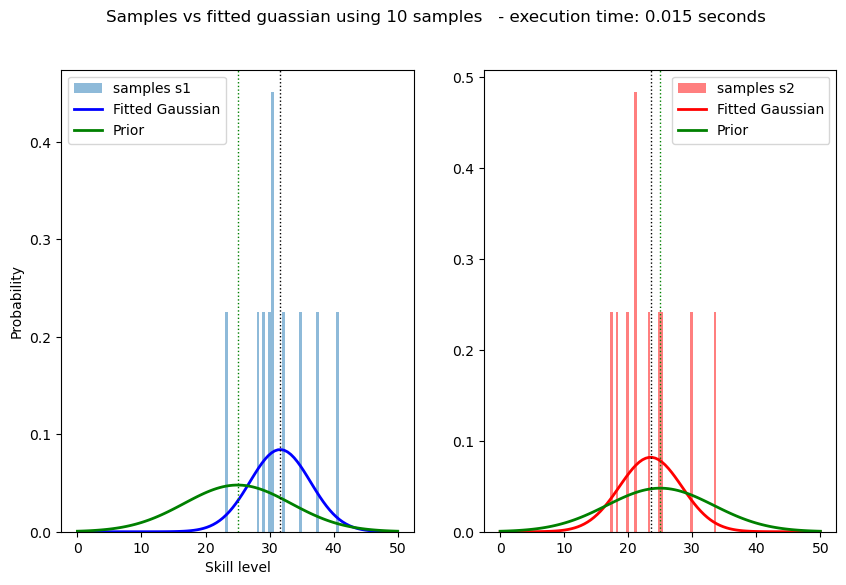

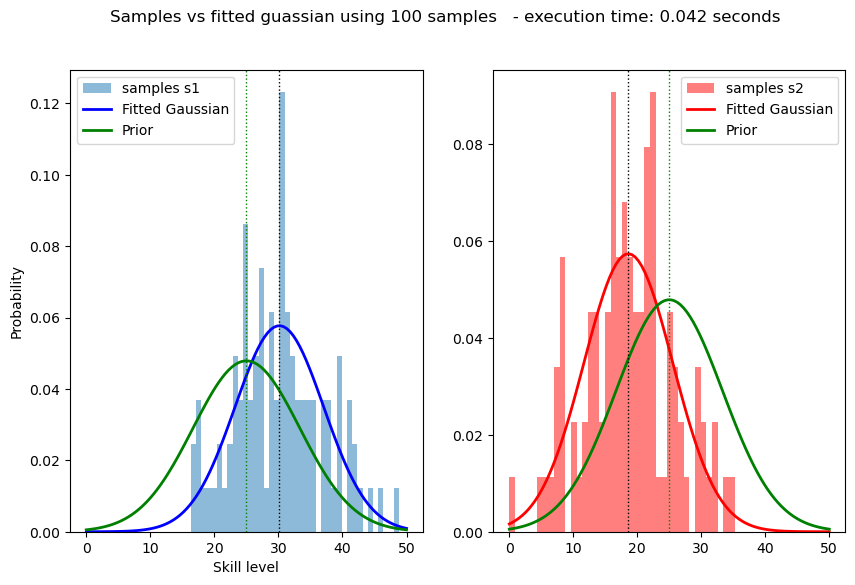

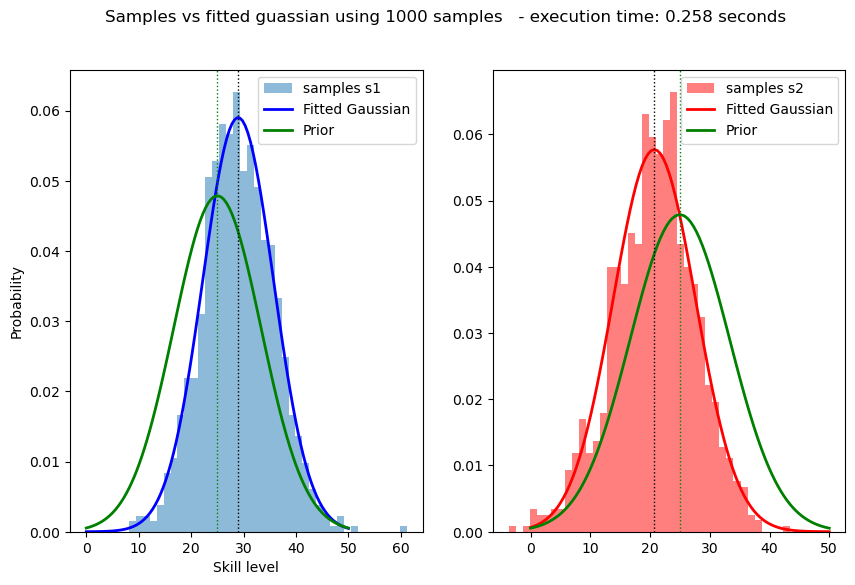

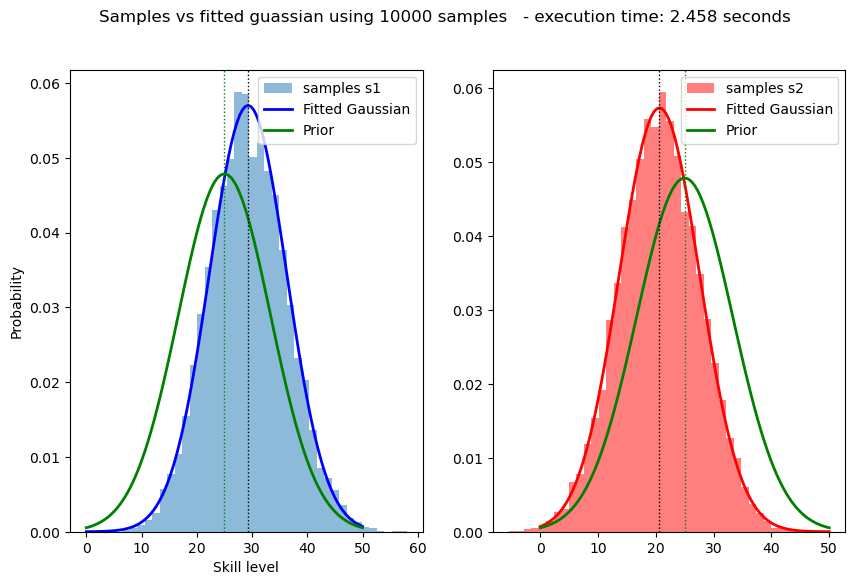

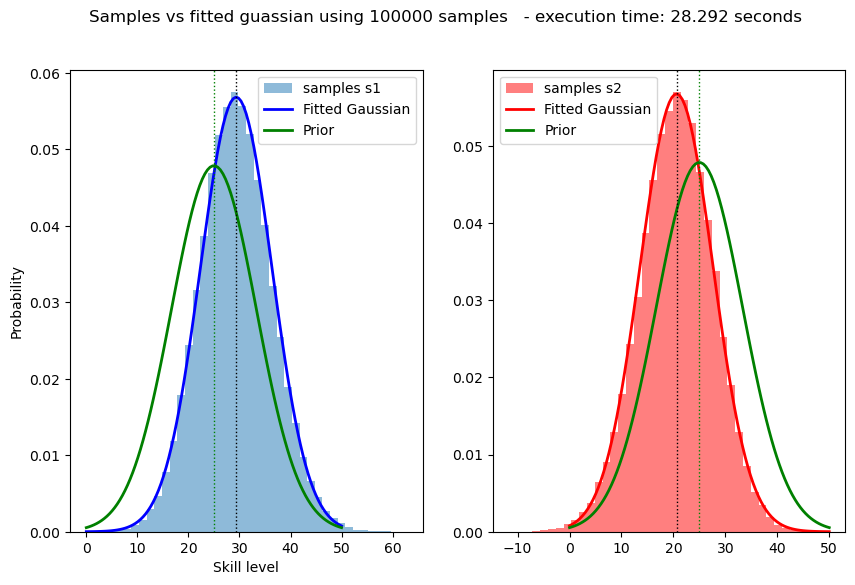

In [4]:
#function that finds the mean and standard deviations from the samples
#generated by the gibbs sampler, together with how long it takes to generate
#the samples.
def approximator(n_samples, y=1, burn_in=50):
  start = time.time()
  samples_s1, samples_s2, iterations = gibbs_sampler(n_samples, y, initial_t=0)
  execution_time = time.time() - start
  mean_s1 = np.mean(samples_s1[burn_in:])
  mean_s2 = np.mean(samples_s2[burn_in:])
  std_s1 = np.std(samples_s1[burn_in:])
  std_s2 = np.std(samples_s2[burn_in:])

  return samples_s1[burn_in:], samples_s2[burn_in:], iterations,\
         execution_time, mean_s1, mean_s2, std_s1, std_s2

burn_in = 50
lst_n_samples = [10, 100, 1000, 10000, 100000]
lst_of_times = []

for n_samples in lst_n_samples:
  samples_s1, samples_s2, iterations, exe_time,\
  mean_s1, mean_s2, std_s1, std_s2 = approximator(n_samples+burn_in)

  lst_of_times.append(exe_time)

  #Setting up figures
  plt.figure(figsize=(10,6))

  x = np.linspace(mu - 3*np.sqrt(sigma), mu + 3*np.sqrt(sigma), 100)

  plt.subplot(121)
  plt.hist(samples_s1, bins=40, alpha=0.5, label='samples s1', density=True)
  posterior_s1 = norm.pdf(x, mean_s1, std_s1)
  prior = norm.pdf(x, mu, np.sqrt(sigma))
  plt.plot(x, posterior_s1, 'blue', linewidth=2, label='Fitted Gaussian')
  plt.plot(x, prior, 'g', linewidth=2, label='Prior')
  plt.xlabel("Skill level")
  plt.ylabel("Probability")
  plt.legend()

  #Plot vertical lines indicating mean for posterior and prior (left plot)
  plt.axvline(x=mean_s1, color='k', linestyle=':', linewidth=1)
  plt.axvline(x=mu, color='green', linestyle=':', linewidth=1)

  plt.subplot(122)
  plt.hist(samples_s2, bins=40, alpha=0.5, label='samples s2', density=True,\
           color='red')

  posterior_s2 = norm.pdf(x, mean_s2, std_s2)
  plt.plot(x, posterior_s2, 'red', linewidth=2, label='Fitted Gaussian')
  plt.plot(x, prior, 'g', linewidth=2, label='Prior')

  #Plot vertical lines indicating mean for posterior and prior (right plot)
  plt.axvline(x=mean_s2, color='k', linestyle=':', linewidth=1)
  plt.axvline(x=mu, color='green', linestyle=':', linewidth=1)

  plt.suptitle(f"Samples vs fitted guassian using {n_samples} samples\
   - execution time: {lst_of_times[-1]:.3f} seconds")
  plt.legend()

  plt.show()

# **Q.5 Assumed Density Filtering (Moment matching)**

In [5]:
# Loading in the raw SerieA file
serieA = pd.read_csv('SerieA.csv', dtype={'ID': str}).dropna()
print(serieA)

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]


We are using the gibbs sampler to get the skills of all teams in Serie A. Since we are only modelling wins or losses, we remove all games ending in a draw.

In [6]:
serieA_win_ratio = serieA

serieA_win_ratio['winner'] = serieA_win_ratio.apply(lambda x: x['team2'] if x['score1'] < x['score2']
                     else (x['team1'] if x['score1'] > x['score2'] else 'TIE'), axis=1)

# Drop rows with 'TIE'
serieA_win_ratio.drop(serieA_win_ratio.loc[serieA_win_ratio['winner'] == 'TIE'].index, inplace=True)

serieA_win_ratio['y'] = serieA_win_ratio.apply((lambda x: 1 if x['winner'] == x['team1'] else -1), axis=1)

# Reset index and reassign
serieA_win_ratio.reset_index(drop=True, inplace=True)

# Assuming you already have the dataframe 'df'
# Create a new column 'loser' which is the team that lost
serieA_win_ratio['loser'] = serieA_win_ratio.apply(lambda row: row['team1'] if row['winner'] == row['team2'] else row['team2'], axis=1)

# Calculate wins: count how many times each team appears as the winner
wins = serieA_win_ratio['winner'].value_counts().reset_index()
wins.columns = ['team', 'wins']

# Calculate losses: count how many times each team appears as the loser
losses = serieA_win_ratio['loser'].value_counts().reset_index()
losses.columns = ['team', 'losses']

# Merge the wins and losses dataframes
team_stats = pd.merge(wins, losses, on='team', how='outer').fillna(0)

# Convert wins and losses to integer type
team_stats['wins'] = team_stats['wins'].astype(int)
team_stats['losses'] = team_stats['losses'].astype(int)
print(team_stats)

          team  wins  losses
0     Juventus    28       4
1       Napoli    24       7
2     Atalanta    20       9
3        Inter    20       9
4        Milan    19       8
5         Roma    18       8
6        Lazio    17      13
7       Torino    16       7
8    Sampdoria    15      15
9         Spal    11      18
10     Udinese    11      17
11     Bologna    11      16
12      Empoli    10      20
13    Cagliari    10      17
14       Parma    10      17
15    Sassuolo     9      13
16       Genoa     8      16
17  Fiorentina     8      13
18   Frosinone     5      23
19      Chievo     2      22


In [7]:
serieA['winner'] = serieA.apply(lambda x: x['team2'] if x['score1'] < x['score2']
                     else (x['team1'] if x['score1'] > x['score2'] else 'TIE'), axis=1)

# Drop rows with 'TIE'
serieA.drop(serieA.loc[serieA['winner'] == 'TIE'].index, inplace=True)

serieA['y'] = serieA.apply((lambda x: 1 if x['winner'] == x['team1'] else -1), axis=1)

serieA = serieA[['team1', 'team2', 'winner', 'y']]

# Reset index and reassign
serieA.reset_index(drop=True, inplace=True)

# Print the updated DataFrame
print(serieA)

        team1     team2    winner  y
0      Chievo  Juventus  Juventus -1
1       Lazio    Napoli    Napoli -1
2      Torino      Roma      Roma -1
3    Sassuolo     Inter  Sassuolo  1
4      Empoli  Cagliari    Empoli  1
..        ...       ...       ... ..
267      Spal     Milan     Milan -1
268      Roma     Parma      Roma  1
269     Inter    Empoli     Inter  1
270  Cagliari   Udinese   Udinese -1
271  Atalanta  Sassuolo  Atalanta  1

[272 rows x 4 columns]


In [8]:
teams1 = serieA['team1'].unique()

All_teams = sorted(teams1)

#Hyperparameters
mu = 25  # prior mean for both players
sigma = 8.333  # prior standard deviation for both players

All_teams_dict = {}

for i in All_teams:
    All_teams_dict[i] = mu, sigma

All_teams_dict

{'Atalanta': (25, 8.333),
 'Bologna': (25, 8.333),
 'Cagliari': (25, 8.333),
 'Chievo': (25, 8.333),
 'Empoli': (25, 8.333),
 'Fiorentina': (25, 8.333),
 'Frosinone': (25, 8.333),
 'Genoa': (25, 8.333),
 'Inter': (25, 8.333),
 'Juventus': (25, 8.333),
 'Lazio': (25, 8.333),
 'Milan': (25, 8.333),
 'Napoli': (25, 8.333),
 'Parma': (25, 8.333),
 'Roma': (25, 8.333),
 'Sampdoria': (25, 8.333),
 'Sassuolo': (25, 8.333),
 'Spal': (25, 8.333),
 'Torino': (25, 8.333),
 'Udinese': (25, 8.333)}

In [9]:
def serieA_gibbs_sampler(num_iterations, y, burn_in, mu1, mu2, sigma1, sigma2):
    A = np.array([[1], [-1]])

    # Initialize s1 and s2 with their prior means
    beta = 25/6
    mu_matrix = np.array([[mu1], [mu2]])
    sig_matrix = np.array([[sigma1, 0], [0, sigma2]])
    t = 0 #Initial guess

    # Store samples of s1 and s2
    samples_s1 = np.zeros(num_iterations - burn_in)
    samples_s2 = np.zeros(num_iterations - burn_in)

    for i in range(num_iterations):

        # Sample s1 given t and s2
        s1, s2 = sample_s(sig_matrix, A, beta, mu_matrix, t)

        # Sample t given s1, s2, and y
        t = sample_t(s1, s2, beta, y)

        # Append samples to lists (after burn-in)
        if i >= burn_in:
            samples_s1[i - burn_in] = s1
            samples_s2[i - burn_in] = s2

    return samples_s1, samples_s2

def serieA_update_ranking(teams_dict, y, team1, team2, mu1, mu2, sigma1, sigma2):
    num_iterations = 10000 #As motivated in Q4.3
    burn_in = 50
    samples_s1, samples_s2 = serieA_gibbs_sampler(num_iterations, y, burn_in, mu1, mu2, sigma1, sigma2)
    teams_dict[team1] = np.mean(samples_s1), np.std(samples_s1)
    teams_dict[team2] = np.mean(samples_s2), np.std(samples_s2)


In [10]:
#Main for running update_ranking function
#Iterate over each row and update the mu & sigma for each team
beta = 25/6
for row in serieA.itertuples(index=False):
        y = row.y
        team1 = row.team1
        team2 = row.team2
        mu1, sigma1 = All_teams_dict[team1]
        mu2, sigma2 = All_teams_dict[team2]

        serieA_update_ranking(All_teams_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)

print(All_teams_dict)

{'Atalanta': (26.789673056773402, 0.9600336658821614), 'Bologna': (24.322346961953517, 0.9665982204316862), 'Cagliari': (23.871909632958396, 0.9653834195417498), 'Chievo': (21.90573322673227, 0.978001156298702), 'Empoli': (24.475991324093346, 0.9589664866325334), 'Fiorentina': (24.69234852340592, 0.9708329082566399), 'Frosinone': (22.41728926412021, 0.9739969410023221), 'Genoa': (24.448284101736046, 0.9627458381754879), 'Inter': (25.84462545472306, 0.9650871153993331), 'Juventus': (27.88922589669706, 0.9705925114109083), 'Lazio': (25.009608694370744, 0.9850883231384322), 'Milan': (26.25201971231455, 0.9798572675530014), 'Napoli': (27.152586067938838, 0.9567514511181318), 'Parma': (23.723236526958008, 0.9694435651437), 'Roma': (26.53802453393894, 0.9744065196684579), 'Sampdoria': (24.80816828470467, 0.9604170216077134), 'Sassuolo': (24.874160387347846, 0.9746023141154649), 'Spal': (24.820688176962356, 0.9789723683431825), 'Torino': (25.901147714224912, 0.9682225583370337), 'Udinese': (2

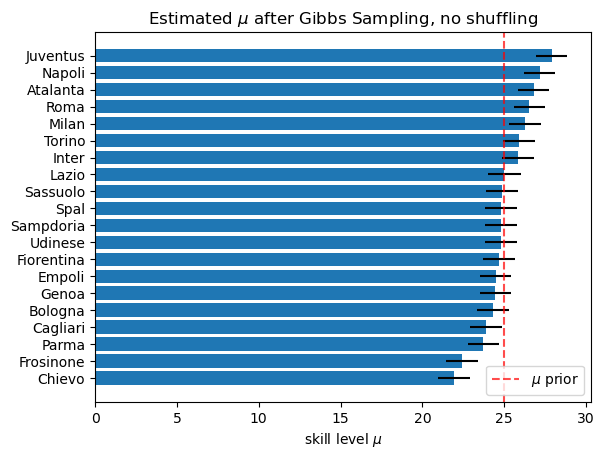

In [11]:
teams_sorted_by_skill = dict(sorted(All_teams_dict.items(), key=lambda x: x[1][0]))

sorted_teams_list = list(teams_sorted_by_skill.keys())
sorted_skills_list = [i[0] for i in list(teams_sorted_by_skill.values())]
sorted_uncertainty_list = [i[1] for i in list(teams_sorted_by_skill.values())]

plt.barh(sorted_teams_list, sorted_skills_list, xerr=sorted_uncertainty_list)
plt.axvline(x=25, color='red', linestyle='--', label=r'$\mu$ prior', alpha=0.7)

plt.title(r'Estimated $\mu$ after Gibbs Sampling, no shuffling')
plt.xlabel('skill level $\mu$')
plt.legend()
plt.show()

In [12]:
# shuffle the DataFrame rows
shuffled_serieA = serieA.sample(frac = 1)

teams1 = shuffled_serieA['team1'].unique()

All_teams = sorted(teams1)

#Hyperparameters
mu = 25  # prior mean for both players
sigma = 8.333  # prior standard deviation for both players

Shuffled_teams_dict = {}

for i in All_teams:
    Shuffled_teams_dict[i] = mu, sigma


shuffled_serieA

,team1,team2,winner,y
94,Parma,Sassuolo,Parma,1
161,Cagliari,Parma,Cagliari,1
140,Sassuolo,Cagliari,Sassuolo,1
8,Napoli,Milan,Napoli,1
129,Parma,Roma,Roma,-1
...,...,...,...,...
33,Torino,Napoli,Napoli,-1
173,Bologna,Juventus,Juventus,-1
216,Atalanta,Bologna,Atalanta,1
225,Milan,Lazio,Milan,1


In [13]:
#Main for running update_ranking function
#Iterate over each row and update the mu & sigma for each team
beta = 25/6
for row in shuffled_serieA.itertuples(index=False):
        y = row.y
        team1 = row.team1
        team2 = row.team2
        mu1, sigma1 = All_teams_dict[team1]
        mu2, sigma2 = All_teams_dict[team2]

        serieA_update_ranking(Shuffled_teams_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)

print(Shuffled_teams_dict)

{'Atalanta': (26.902730549885884, 0.9688550102118054), 'Bologna': (24.227980065735863, 0.9699021732422701), 'Cagliari': (23.696759166369162, 0.9620040223552998), 'Chievo': (21.803624216306652, 0.9765132949115256), 'Empoli': (24.63499007370806, 0.9666630523445099), 'Fiorentina': (24.470007217820037, 0.9674408577532213), 'Frosinone': (22.34772643026552, 0.9873622257891261), 'Genoa': (24.55340023341845, 0.9632928977246439), 'Inter': (25.95702107297408, 0.9701395108611036), 'Juventus': (27.96053106180462, 0.973906343370756), 'Lazio': (24.87352850137218, 0.9793433226026935), 'Milan': (26.41320191714427, 0.9779584384265995), 'Napoli': (27.287747775584712, 0.9686806182206793), 'Parma': (23.971951490779187, 0.9634521269030641), 'Roma': (26.665260182556352, 0.9770372721178533), 'Sampdoria': (24.95126030327102, 0.9637338428765827), 'Sassuolo': (24.742227585360183, 0.9665133567673726), 'Spal': (24.677951384683407, 0.9600614986268425), 'Torino': (25.771625782316686, 0.963707702976283), 'Udinese': 

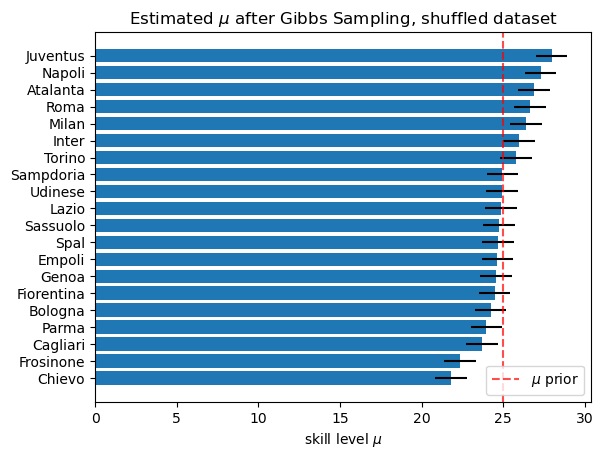

In [14]:
shuffled_teams_sorted_by_skill = dict(sorted(Shuffled_teams_dict.items(), key=lambda x: x[1][0]))

sorted_shuffled_teams_list = list(shuffled_teams_sorted_by_skill.keys())
sorted_shuffled_skills_list = [i[0] for i in list(shuffled_teams_sorted_by_skill.values())]
sorted_shuffled_uncertainty_list = [i[1] for i in list(shuffled_teams_sorted_by_skill.values())]

plt.barh(sorted_shuffled_teams_list, sorted_shuffled_skills_list, xerr=sorted_shuffled_uncertainty_list)
plt.axvline(x=25, color='red', linestyle='--', label=r'$\mu$ prior', alpha=0.7)

plt.title(r'Estimated $\mu$ after Gibbs Sampling, shuffled dataset')
plt.xlabel('skill level $\mu$')
plt.legend()
plt.show()

# **Q6 Using the model for predictions**

When using the model for prediction we are being a bit naïve and assuming that the home team wins when the both teams have the same $\mu$.

In [15]:
teams1 = serieA['team1'].unique()

All_teams = sorted(teams1)

#Hyperparameters
mu = 25  # prior mean for both players
sigma = 8.333  # prior standard deviation for both players

All_teams_pred_dict = {}

for i in All_teams:
    All_teams_pred_dict[i] = mu, sigma

In [16]:
def prediction(mu1, mu2):
    return 1 if mu1 > mu2 else -1

correct_guess = 0
total_guess = 0

beta = 25/6
for row in serieA.itertuples(index=False):
        y = row.y
        team1 = row.team1
        team2 = row.team2
        mu1, sigma1 = All_teams_dict[team1]
        mu2, sigma2 = All_teams_dict[team2]

        pred = prediction(mu1, mu2)
        if pred == y:
            correct_guess += 1

        serieA_update_ranking(All_teams_pred_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)

        total_guess += 1

print(f"total guesses = {total_guess}")
print(f"correct guesses = {correct_guess}")
print(f"r = {correct_guess/total_guess}")

total guesses = 272
correct guesses = 197
r = 0.7242647058823529


# **Q.8 - A message-passing algorithm**

In [17]:
"""
Functions from lessons, to compute multiplication/division & 
truncated gaussian distributions
"""
def mutiplyGauss (m1 , s1 , m2 , s2):
  # computes the Gaussian distribution N(m,s)
  #being propotional to N(m1 ,s1)*N(m2 ,s2)
  #
  # Input :
  # m1 , s1: mean and variance of first Gaussian
  # m2 , s2: mean and variance of second Gaussian
  #
  # Output :
  # m, s: mean and variance of the product Gaussian

  s = 1/(1/s1 + 1/s2)
  m = s*(m1/s1 + m2/s2)
  return m, s


def divideGauss (m1 , s1 , m2 , s2):
# computes the Gaussian distribution N(m,s)
#being propotional to N(m1 ,s1)/N(m2 ,s2)
#
# Input :
# m1 , s1: mean and variance of the numerator Gaussian
# m2 , s2: mean and variance of the denominator Gaussian
#
# Output :
# m, s: mean and variance of the quotient Gaussian

  m, s = mutiplyGauss(m1, s1, m2, -s2)
  return m, s


def truncGaussMM (a, b, m0 , s0):
# computes the mean and variance of a truncated Gaussian distribution
#
# Input :
# a, b: The interval [a, b] on which the Gaussian is being truncated
# m0 ,s0: mean and variance of the Gaussian which is to be truncated

#
# Output :
# m, s: mean and variance of the truncated Gaussian

# scale interval with mean and variance
  a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
  m = truncnorm.mean(a_scaled , b_scaled , loc=m0 , scale = np.sqrt(s0))
  s = truncnorm.var(a_scaled , b_scaled , loc=m0 , scale = np.sqrt(s0))
  return m, s

Defining the messages and how they affect eachother. Then creating the plot for Q.8, plotting the approximation of the posterior from message-passing and gibbs sampler, together with the generated samples.

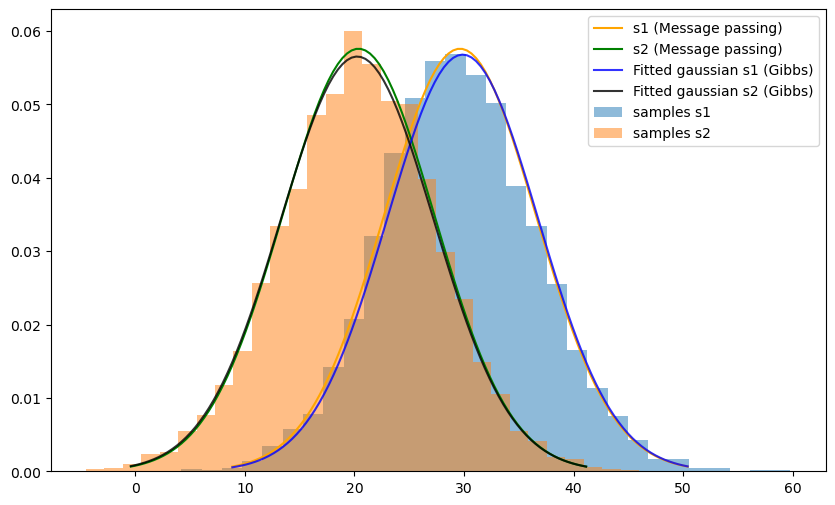

Gibbs sampling s1: mean: 29.545838240493463, variance: 49.350629553636495
Gibbs sampling s2: mean: 20.455313696971487, variance: 49.80774808070849
Message passing s1: mean: 29.632604292541036, variance: 47.98342191317485
Message passing s2: mean: 20.367395707458968, variance: 47.98342191317485


In [18]:
#Defining initial hyperparameters
mu_1 = 25
mu_2 = 25
sigma_1 = (25/3) ** 2
sigma_2 = (25/3) ** 2
beta = 25/6
y = 1

"""Message passing algorithm"""
#mean and variance of messages in the factor graph

#From factor node f_s1 to variable node s_1
mu_1_mean = mu_1
mu_1_var = sigma_1

#From factor node f_s2 to variable node s_2
mu_2_mean = mu_2
mu_2_var = sigma_2

#From variable node s_1 to factor node f_s1,s2,t
mu_3_mean = mu_1_mean
mu_3_var = mu_1_var

#From variable node s_2 to factor node f_s1,s2,t
mu_4_mean = mu_2_mean
mu_4_var = mu_2_var

#From factor node f_s1,s2,t to variable node t
mu_5_mean = mu_1_mean - mu_2_mean
mu_5_var = mu_1_var + mu_2_var + beta

#mu_7, which comes from mu_6 contributes with a truncated gaussian.
#Moment matching is needed at p(t|y).

if y == 1:
  a, b = 0, np.inf
else:
  a, b = -np.inf, 0

p_t_mean, p_t_var = truncGaussMM(a, b, mu_5_mean, mu_5_var)

#From variable node t back to factor node f_s1,s2t
mu_8_mean, mu_8_var = divideGauss(p_t_mean, p_t_var, mu_5_mean, mu_5_var)

#message back to s1
mu_9_mean = mu_4_mean + mu_8_mean
mu_9_var = mu_8_var + mu_4_var + beta

#message back to s2
mu_10_mean = mu_3_mean - mu_8_mean
mu_10_var = mu_3_var + mu_8_var + beta

#Computing mean and variance for marginal of s1 and s2
p_s1_mean, p_s1_var = mutiplyGauss(mu_3_mean, mu_3_var, mu_9_mean, mu_9_var)
p_s2_mean, p_s2_var = mutiplyGauss(mu_4_mean, mu_4_var, mu_10_mean, mu_10_var)

"""Gibbs sampling"""
num_iterations = 10000
initial_t = 0
y = 1  # Player 1 wins
burn_in = 50
samples_s1, samples_s2, _, _,\
s1_mean, s2_mean, s1_std, s2_std = approximator(num_iterations, y, burn_in)


pdf_gibbs_s1 = stats.norm.pdf(x1, s1_mean, s1_std)
pdf_gibbs_s2 = stats.norm.pdf(x2, s2_mean, s2_std)


#Setting up figures for comparing message-passing posterior, gibbs sampling
#posterior and the actual samples s1 and s2.
x_axis_s1 = np.linspace(p_s1_mean-3*np.sqrt(p_s1_var),\
                        p_s1_mean+3*np.sqrt(p_s1_var), 100)

x_axis_s2 = np.linspace(p_s2_mean-3*np.sqrt(p_s2_var),\
                        p_s2_mean+3*np.sqrt(p_s2_var), 100)

pdf_mp_s1 = norm.pdf(x_axis_s1, p_s1_mean, np.sqrt(p_s1_var))
pdf_mp_s2 = norm.pdf(x_axis_s2, p_s2_mean, np.sqrt(p_s2_var))

plt.figure(figsize=(10,6))
plt.plot(x_axis_s1, pdf_mp_s1, 'orange', label='s1 (Message passing)')
plt.plot(x_axis_s2, pdf_mp_s2, 'green', label='s2 (Message passing)')

plt.plot(x_axis_s1, pdf_gibbs_s1, 'b', label="Fitted gaussian s1 (Gibbs)",\
         alpha=0.8)
plt.plot(x_axis_s2, pdf_gibbs_s2, 'k', label="Fitted gaussian s2 (Gibbs)",\
         alpha=0.8)

plt.hist(samples_s1, bins=30, alpha=0.5, label='samples s1', density=True)
plt.hist(samples_s2, bins=30, alpha=0.5, label='samples s2', density=True)
plt.legend()
plt.show()

print(f"Gibbs sampling s1: mean: {s1_mean}, variance: {s1_std**2}")
print(f"Gibbs sampling s2: mean: {s2_mean}, variance: {s2_std**2}")
print(f"Message passing s1: mean: {p_s1_mean}, variance: {p_s1_var}")
print(f"Message passing s2: mean: {p_s2_mean}, variance: {p_s2_var}")


# **Q.9 Your own data (UFC Dataset)**

We are using the fighters weight as a prior, assuming that fighters that weight more have a bettter chance of winning.

In [19]:
import pandas as pd
import numpy as np
data_fights = pd.read_csv('fights-with-winner.csv', delimiter=';')
data_fighters = pd.read_csv('ufc-fighters-statistics.csv', delimiter=',')

data_fights = data_fights.dropna(subset=['Winner'])
data_fights.reset_index(inplace = True, drop = True)

data_fighters = data_fighters[['name','weight_in_kg']]
data_fighters = data_fighters.drop_duplicates(subset='name', keep='first')

# Step 1: Extract the unique names from R_fighter and B_fighter columns in data_fights
fighters_in_fights = pd.concat([data_fights['R_fighter'], data_fights['B_fighter']]).unique()

# Step 2: Filter data_fighters to keep only rows where 'name' appears in fighters_in_fights
filtered_fighters = data_fighters[data_fighters['name'].isin(fighters_in_fights)]
filtered_fighters.reset_index(inplace = True, drop = True)
# Now `filtered_fighters` contains only the fighters that appear in R_fighter or B_fighter

# Step 3: Add new column y
data_fights['y'] = data_fights.apply((lambda x: 1 if x['Winner'] == x['R_fighter'] else -1), axis=1)

# Step 4: Computing the prior based on the fighter's proportional weight * 25
total_weight = filtered_fighters['weight_in_kg'].mean()
filtered_fighters['prior skill'] = filtered_fighters.apply(lambda x: ((x['weight_in_kg']/(total_weight))*25), axis=1)

print(data_fights, '\n')
print(filtered_fighters)

          R_fighter           B_fighter             Winner  y
0      Adrian Yanez       Gustavo Lopez       Adrian Yanez  1
1      Trevin Giles       Roman Dolidze       Trevin Giles  1
2       Tai Tuivasa     Harry Hunsucker        Tai Tuivasa  1
3     Cheyanne Buys   Montserrat Conejo  Montserrat Conejo -1
4     Marion Reneau       Macy Chiasson      Macy Chiasson -1
...             ...                 ...                ... ..
5897  Remco Pardoel  Alberta Cerra Leon      Remco Pardoel  1
5898   Orlando Wiet    Robert Lucarelli       Orlando Wiet  1
5899  Johnny Rhodes       David Levicki      Johnny Rhodes  1
5900  Patrick Smith          Ray Wizard      Patrick Smith  1
5901   Scott Morris      Sean Daugherty       Scott Morris  1

[5902 rows x 4 columns] 

                   name  weight_in_kg  prior skill
0      Gerald Strebendt         70.31    22.538073
1            Neil Grove        120.20    38.530457
2         Ian Entwistle         61.23    19.627453
3         Josh Rafferty  

C:\Users\cooli\AppData\Local\Temp\ipykernel_21844\3901816031.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fighters['prior skill'] = filtered_fighters.apply(lambda x: ((x['weight_in_kg']/(total_weight))*25), axis=1)


In [20]:
#Initializing dictionary with prior and sigma at 25/3
all_fighters_dict = {}

fighter_sigma = 25/3

names = filtered_fighters['name']

prior_skills = filtered_fighters['prior skill']

for i in range(len(names)):
  all_fighters_dict[names[i]] = prior_skills[i], fighter_sigma

all_fighters_dict

{'Gerald Strebendt': (22.538073498669714, 8.333333333333334),
 'Neil Grove': (38.53045704082065, 8.333333333333334),
 'Ian Entwistle': (19.6274532829405, 8.333333333333334),
 'Josh Rafferty': (24.717833131594674, 8.333333333333334),
 'Jeff Newton': (29.80821298024885, 8.333333333333334),
 'Ansar Chalangov': (24.717833131594674, 8.333333333333334),
 'Paul Sass': (22.538073498669714, 8.333333333333334),
 'James Lee': (29.80821298024885, 8.333333333333334),
 'Jason Black': (22.538073498669714, 8.333333333333334),
 'John Albert': (19.6274532829405, 8.333333333333334),
 'David Terrell': (26.897592764519633, 8.333333333333334),
 'Rob MacDonald': (29.80821298024885, 8.333333333333334),
 'Matt Arroyo': (24.717833131594674, 8.333333333333334),
 'Colin Robinson': (35.33133922661607, 8.333333333333334),
 'Justin Levens': (26.897592764519633, 8.333333333333334),
 'Mike Ciesnolevicz': (34.16773224609877, 8.333333333333334),
 'Alex Schoenauer': (26.897592764519633, 8.333333333333334),
 'TJ Waldburge

In [21]:
def ufc_gibbs_sampler(num_iterations, y, burn_in, mu1, mu2, sigma1, sigma2):
    A = np.array([[1], [-1]])
    beta = 25/6
    mu_matrix = np.array([[mu1], [mu2]])
    sig_matrix = np.array([[sigma1, 0], [0, sigma2]])
    t = 0 #Initial guess

    samples_s1 = np.zeros(num_iterations - burn_in)
    samples_s2 = np.zeros(num_iterations - burn_in)

    for i in range(num_iterations):
        s1, s2 = sample_s(sig_matrix, A, beta, mu_matrix, t)
        t = sample_t(s1, s2, beta, y)

        if i >= burn_in:
            samples_s1[i - burn_in] = s1
            samples_s2[i - burn_in] = s2

    return samples_s1, samples_s2

def ufc_update_ranking(teams_dict, y, team1, team2, mu1, mu2, sigma1, sigma2):
    num_iterations = 1000
    burn_in = 50
    samples_s1, samples_s2 = ufc_gibbs_sampler(num_iterations, y, burn_in, mu1, mu2, sigma1, sigma2)
    teams_dict[team1] = np.mean(samples_s1), np.std(samples_s1)
    teams_dict[team2] = np.mean(samples_s2), np.std(samples_s2)

In [22]:
def prediction(mu1, mu2):
    return 1 if mu1 > mu2 else -1

correct_guess = 0
total_guess = 0

for row in data_fights.itertuples(index=False):
    y = row.y
    team1 = row.R_fighter
    team2 = row.B_fighter
    if team1 not in all_fighters_dict:
        all_fighters_dict[team1] = 25, fighter_sigma
    if team2 not in all_fighters_dict:
        all_fighters_dict[team2] = 25, fighter_sigma
    mu1, sigma1 = all_fighters_dict[team1]
    mu2, sigma2 = all_fighters_dict[team2]

    pred = prediction(mu1, mu2)
    if pred == y:
        correct_guess += 1

    #Handling errors (debugging method)
    try:
        ufc_update_ranking(all_fighters_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)
    except ValueError:
        print(y, team1, team2, mu1, mu2, sigma1, sigma2)
        print(all_fighters_dict)

    total_guess += 1

    if total_guess%300==0:
        print(f"Iteration: {total_guess}")
        print(all_fighters_dict)
        print(f"beta: {beta}")

print(all_fighters_dict, '\n')
print(f"total guesses = {total_guess}")
print(f"correct guesses = {correct_guess}")
print(f"r = {correct_guess/total_guess}")

Iteration: 300
{'Gerald Strebendt': (22.538073498669714, 8.333333333333334), 'Neil Grove': (38.53045704082065, 8.333333333333334), 'Ian Entwistle': (19.6274532829405, 8.333333333333334), 'Josh Rafferty': (24.717833131594674, 8.333333333333334), 'Jeff Newton': (29.80821298024885, 8.333333333333334), 'Ansar Chalangov': (24.717833131594674, 8.333333333333334), 'Paul Sass': (22.538073498669714, 8.333333333333334), 'James Lee': (29.80821298024885, 8.333333333333334), 'Jason Black': (22.538073498669714, 8.333333333333334), 'John Albert': (19.6274532829405, 8.333333333333334), 'David Terrell': (26.897592764519633, 8.333333333333334), 'Rob MacDonald': (29.80821298024885, 8.333333333333334), 'Matt Arroyo': (24.717833131594674, 8.333333333333334), 'Colin Robinson': (35.33133922661607, 8.333333333333334), 'Justin Levens': (26.897592764519633, 8.333333333333334), 'Mike Ciesnolevicz': (34.16773224609877, 8.333333333333334), 'Alex Schoenauer': (26.897592764519633, 8.333333333333334), 'TJ Waldburger'

# **Q.10 Open ended project extension**

For the open ended extension we made a stochastic predictor to make games where both players are similiarly skilled more fair. We now take 1 sample from both players distribution and compare them to see who wins. Making the predictor more fair when two players are similiarly matched.  

In [23]:
#Re-initializing a clean dictionary for storing all teams
teams1 = serieA['team1'].unique()

All_teams = sorted(teams1)

#Hyperparameters
mu = 25  # prior mean for both players
sigma = 25/3  # prior standard deviation for both players

All_teams_stochastic_dict = {}

for i in All_teams:
    All_teams_stochastic_dict[i] = mu, sigma

All_teams_stochastic_dict

{'Atalanta': (25, 8.333333333333334),
 'Bologna': (25, 8.333333333333334),
 'Cagliari': (25, 8.333333333333334),
 'Chievo': (25, 8.333333333333334),
 'Empoli': (25, 8.333333333333334),
 'Fiorentina': (25, 8.333333333333334),
 'Frosinone': (25, 8.333333333333334),
 'Genoa': (25, 8.333333333333334),
 'Inter': (25, 8.333333333333334),
 'Juventus': (25, 8.333333333333334),
 'Lazio': (25, 8.333333333333334),
 'Milan': (25, 8.333333333333334),
 'Napoli': (25, 8.333333333333334),
 'Parma': (25, 8.333333333333334),
 'Roma': (25, 8.333333333333334),
 'Sampdoria': (25, 8.333333333333334),
 'Sassuolo': (25, 8.333333333333334),
 'Spal': (25, 8.333333333333334),
 'Torino': (25, 8.333333333333334),
 'Udinese': (25, 8.333333333333334)}

In [24]:
def prediction(mu1, sigma1, mu2, sigma2):
    # For the first instances we give the advantage to the home team
    if ((mu1 == mu2) & (sigma1 == sigma2)):
       return 1

    s1 = np.random.normal(mu1, np.sqrt(sigma1))
    s2 = np.random.normal(mu2, np.sqrt(sigma2))
    return 1 if s1 > s2 else -1

correct_guess = 0
total_guess = 0

#Iterate over each row, predict and then update
for row in serieA.itertuples(index=False):
        y = row.y
        team1 = row.team1
        team2 = row.team2
        mu1, sigma1 = All_teams_stochastic_dict[team1]
        mu2, sigma2 = All_teams_stochastic_dict[team2]

        pred = prediction(mu1, sigma1, mu2, sigma2)
        if pred == y:
            correct_guess += 1

        serieA_update_ranking(All_teams_stochastic_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)

        total_guess += 1

print(All_teams_stochastic_dict)
print(f"total guesses = {total_guess}")
print(f"correct guesses = {correct_guess}")
print(f"r = {correct_guess/total_guess}")

{'Atalanta': (26.784657659357592, 0.9659398307993323), 'Bologna': (24.331499547426905, 0.9618319571717818), 'Cagliari': (23.927462441787565, 0.9708953112376891), 'Chievo': (21.90762200623285, 0.9593265228725951), 'Empoli': (24.36881328092176, 0.959531077672039), 'Fiorentina': (24.682356262813947, 0.965475454767082), 'Frosinone': (22.38665095538866, 0.981877739087914), 'Genoa': (24.350036011061665, 0.9722089356785495), 'Inter': (25.89672526236707, 0.9778258923362135), 'Juventus': (27.851518516486678, 0.9647724298673386), 'Lazio': (25.02240376109537, 0.9584206085955246), 'Milan': (26.25821235412815, 0.9695193231735879), 'Napoli': (27.282688553124196, 0.9679113831335642), 'Parma': (23.6596035823754, 0.9700634214965146), 'Roma': (26.49534317298329, 0.9751860853317907), 'Sampdoria': (24.732783638830647, 0.9764663688792216), 'Sassuolo': (24.864486961989584, 0.9694134281365429), 'Spal': (24.79772157585683, 0.9702502832196892), 'Torino': (25.89210971538018, 0.9575069059270297), 'Udinese': (24.

In [25]:
##Re-initializing a clean dictionary for all fighters
all_fighters_stochastic_dict = {}

fighter_sigma = 25/3

names = filtered_fighters['name']

prior_skills = filtered_fighters['prior skill']

for i in range(len(names)):
  all_fighters_stochastic_dict[names[i]] = prior_skills[i], fighter_sigma

all_fighters_stochastic_dict

{'Gerald Strebendt': (22.538073498669714, 8.333333333333334),
 'Neil Grove': (38.53045704082065, 8.333333333333334),
 'Ian Entwistle': (19.6274532829405, 8.333333333333334),
 'Josh Rafferty': (24.717833131594674, 8.333333333333334),
 'Jeff Newton': (29.80821298024885, 8.333333333333334),
 'Ansar Chalangov': (24.717833131594674, 8.333333333333334),
 'Paul Sass': (22.538073498669714, 8.333333333333334),
 'James Lee': (29.80821298024885, 8.333333333333334),
 'Jason Black': (22.538073498669714, 8.333333333333334),
 'John Albert': (19.6274532829405, 8.333333333333334),
 'David Terrell': (26.897592764519633, 8.333333333333334),
 'Rob MacDonald': (29.80821298024885, 8.333333333333334),
 'Matt Arroyo': (24.717833131594674, 8.333333333333334),
 'Colin Robinson': (35.33133922661607, 8.333333333333334),
 'Justin Levens': (26.897592764519633, 8.333333333333334),
 'Mike Ciesnolevicz': (34.16773224609877, 8.333333333333334),
 'Alex Schoenauer': (26.897592764519633, 8.333333333333334),
 'TJ Waldburge

In [27]:
def prediction(mu1, sigma1, mu2, sigma2):
    # For the first instances we give the advantage to the home team
    if ((mu1 == mu2) & (sigma1 == sigma2)):
       return 1

    s1 = np.random.normal(mu1, np.sqrt(sigma1))
    s2 = np.random.normal(mu2, np.sqrt(sigma2))
    return 1 if s1 > s2 else -1

correct_guess = 0
total_guess = 0

for row in data_fights.itertuples(index=False):
    y = row.y
    team1 = row.R_fighter
    team2 = row.B_fighter
    if team1 not in all_fighters_dict:
        all_fighters_dict[team1] = 25, fighter_sigma
    if team2 not in all_fighters_dict:
        all_fighters_dict[team2] = 25, fighter_sigma
    mu1, sigma1 = all_fighters_dict[team1]
    mu2, sigma2 = all_fighters_dict[team2]

    pred = prediction(mu1, sigma1, mu2, sigma2)
    if pred == y:
        correct_guess += 1

    ufc_update_ranking(all_fighters_dict, y, team1, team2, mu1, mu2, sigma1, sigma2)

    total_guess += 1

    if total_guess%1000==0:
        print(f"Iteration: {total_guess}")

print(all_fighters_dict, '\n')
print(f"total guesses = {total_guess}")
print(f"correct guesses = {correct_guess}")
print(f"r = {correct_guess/total_guess}")

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
{'Gerald Strebendt': (20.40022469295797, 1.508490066963989), 'Neil Grove': (34.94180417768518, 1.6017373010271783), 'Ian Entwistle': (18.63142185827018, 0.9871272438859523), 'Josh Rafferty': (22.148186379535577, 1.509704795945976), 'Jeff Newton': (27.654071972391517, 1.4804217244886635), 'Ansar Chalangov': (22.709056206683773, 1.0648147855712022), 'Paul Sass': (21.34522278665806, 0.9464897669891615), 'James Lee': (26.80571534865206, 1.474620327619328), 'Jason Black': (19.46956121555587, 1.108869140862801), 'John Albert': (17.46726780164358, 0.9366911449944921), 'David Terrell': (27.500060089136852, 0.9382408975779313), 'Rob MacDonald': (27.257961202778418, 1.0440161979673404), 'Matt Arroyo': (23.144900987338467, 1.0048404834543025), 'Colin Robinson': (32.63183372631537, 1.0435778355145668), 'Justin Levens': (23.766954510521366, 1.1025459862315596), 'Mike Ciesnolevicz': (31.954768533459422, 1.039090500487323